In [180]:
#Setup
import pandas as pd
from pathlib import Path
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats


In [181]:
#Load Files
NSCLC_path = Path("resources/nsclc_tcga_broad_2016_clinical_data.tsv")

In [182]:
#Read Files
NSCLC = pd.read_csv(NSCLC_path, sep='\t')

In [183]:
#Make DataFrame 2023
NSCLC_df = pd.DataFrame(NSCLC)
NSCLC_df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Age At Surgery,Cancer Type,Cancer Type Detailed,Death from Initial Pathologic Diagnosis Date,Days to Last Followup,Fraction Genome Altered,...,Overall Survival (Months),Overall Survival Status,Number of Samples Per Patient,Sex,Smoking History,Person Cigarette Smoking History Pack Year Value,Somatic Status,Stage,TMB (nonsynonymous),T Stage
0,nsclc_tcga_broad_2016,LUAD-2GUGK,LUAD-2GUGK-Tumor,NaN,68.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0174,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",30.00,Matched,IIA,7.933333,NaN
1,nsclc_tcga_broad_2016,LUAD-5O6B5,LUAD-5O6B5-Tumor,NaN,56.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0356,...,NaN,NaN,1,Female,Lifelong Non-Smoker,0.00,Matched,IB,1.033333,NaN
2,nsclc_tcga_broad_2016,LUAD-5V8LT,LUAD-5V8LT-Tumor,NaN,52.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.3895,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",6.00,Matched,IB,49.433333,NaN
3,nsclc_tcga_broad_2016,LUAD-74TBW,LUAD-74TBW-Tumor,NaN,73.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1757,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",61.25,Matched,IB,7.800000,NaN
4,nsclc_tcga_broad_2016,LUAD-AEIUF,LUAD-AEIUF-Tumor,NaN,60.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1942,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",73.50,Matched,NaN,5.333333,NaN


In [184]:
rename_NSCLC_df = NSCLC_df.rename(columns={
    'Cancer Type Detailed': 'Cancer Subtype',
    'Person Cigarette Smoking History Pack Year Value': 'Lifetime Tobacco Exposure',
})

rename_NSCLC_df.head()

,Study ID,Patient ID,Sample ID,Diagnosis Age,Age At Surgery,Cancer Type,Cancer Subtype,Death from Initial Pathologic Diagnosis Date,Days to Last Followup,Fraction Genome Altered,...,Overall Survival (Months),Overall Survival Status,Number of Samples Per Patient,Sex,Smoking History,Lifetime Tobacco Exposure,Somatic Status,Stage,TMB (nonsynonymous),T Stage
0,nsclc_tcga_broad_2016,LUAD-2GUGK,LUAD-2GUGK-Tumor,NaN,68.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0174,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",30.00,Matched,IIA,7.933333,NaN
1,nsclc_tcga_broad_2016,LUAD-5O6B5,LUAD-5O6B5-Tumor,NaN,56.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.0356,...,NaN,NaN,1,Female,Lifelong Non-Smoker,0.00,Matched,IB,1.033333,NaN
2,nsclc_tcga_broad_2016,LUAD-5V8LT,LUAD-5V8LT-Tumor,NaN,52.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.3895,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",6.00,Matched,IB,49.433333,NaN
3,nsclc_tcga_broad_2016,LUAD-74TBW,LUAD-74TBW-Tumor,NaN,73.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1757,...,NaN,NaN,1,Male,"Current Reformed Smoker, Duration Not Specified",61.25,Matched,IB,7.800000,NaN
4,nsclc_tcga_broad_2016,LUAD-AEIUF,LUAD-AEIUF-Tumor,NaN,60.0,Non-Small Cell Lung Cancer,Lung Adenocarcinoma,NaN,NaN,0.1942,...,NaN,NaN,1,Female,"Current Reformed Smoker, Duration Not Specified",73.50,Matched,NaN,5.333333,NaN


In [185]:
columns_to_keep = ['Patient ID', 'Cancer Subtype', 'Overall Survival (Months)', 'Mutation Count', 'TMB (nonsynonymous)','Lifetime Tobacco Exposure']


survival_NSCLC_df = rename_NSCLC_df[columns_to_keep]

survival_NSCLC_df.head()

,Patient ID,Cancer Subtype,Overall Survival (Months),Mutation Count,TMB (nonsynonymous),Lifetime Tobacco Exposure
0,LUAD-2GUGK,Lung Adenocarcinoma,NaN,238,7.933333,30.00
1,LUAD-5O6B5,Lung Adenocarcinoma,NaN,31,1.033333,0.00
2,LUAD-5V8LT,Lung Adenocarcinoma,NaN,1483,49.433333,6.00
3,LUAD-74TBW,Lung Adenocarcinoma,NaN,233,7.800000,61.25
4,LUAD-AEIUF,Lung Adenocarcinoma,NaN,161,5.333333,73.50


In [186]:
survival_NSCLC_df.dropna()

,Patient ID,Cancer Subtype,Overall Survival (Months),Mutation Count,TMB (nonsynonymous),Lifetime Tobacco Exposure
159,TCGA-05-4244,Lung Adenocarcinoma,0.00,189,6.300000,38.0
160,TCGA-05-4249,Lung Adenocarcinoma,38.10,288,9.633333,52.0
161,TCGA-05-4250,Lung Adenocarcinoma,4.00,296,9.833333,47.0
162,TCGA-05-4382,Lung Adenocarcinoma,20.00,1625,54.233333,62.0
163,TCGA-05-4384,Lung Adenocarcinoma,14.00,122,4.066667,20.0
...,...,...,...,...,...,...
1139,TCGA-O2-A52V,Lung Squamous Cell Carcinoma,43.91,211,7.033333,1.0
1140,TCGA-O2-A52W,Lung Squamous Cell Carcinoma,8.59,101,3.400000,2.5
1141,TCGA-O2-A5IB,Lung Squamous Cell Carcinoma,11.18,216,7.200000,2.5
1142,TCGA-S2-AA1A,Lung Adenocarcinoma,4.00,109,3.633333,95.0


In [187]:
bins = list(range(0, 126, 6))  # Create bins from 0 to 120 in increments of 6
labels = [f'{i}-{i + 6}' for i in bins[:-1]]  # Create labels for the bins

# Create a new column for binned survival months
survival_NSCLC_df['Survival Binned'] = pd.cut(survival_NSCLC_df['Overall Survival (Months)'], bins=bins, labels=labels, right=False)

# Group by the binned survival months and count unique Patient IDs
counts_survival_NSCLC_df = survival_NSCLC_df.groupby('Survival Binned')['Patient ID'].nunique().reset_index()

# Rename the count column for clarity
counts_survival_NSCLC_df.columns = ['Survival Binned', 'Unique Patient Count']

# Display the result
print(counts_survival_NSCLC_df)

   Survival Binned  Unique Patient Count
0              0-6                   412
1             6-12                   138
2            12-18                    77
3            18-24                    57
4            24-30                    51
5            30-36                    42
6            36-42                    36
7            42-48                    31
8            48-54                    18
9            54-60                    24
10           60-66                    12
11           66-72                    13
12           72-78                     6
13           78-84                     6
14           84-90                     5
15           90-96                     3
16          96-102                     3
17         102-108                     4
18         108-114                     2
19         114-120                     5


C:\Users\nefer\AppData\Local\Temp\ipykernel_32884\1955539948.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_NSCLC_df['Survival Binned'] = pd.cut(survival_NSCLC_df['Overall Survival (Months)'], bins=bins, labels=labels, right=False)
C:\Users\nefer\AppData\Local\Temp\ipykernel_32884\1955539948.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_survival_NSCLC_df = survival_NSCLC_df.groupby('Survival Binned')['Patient ID'].nunique().reset_index()


In [188]:
survival_NSCLC_df['Survival Binned2'] = pd.cut(
    survival_NSCLC_df['Overall Survival (Months)'], 
    bins=[-1, 6, float('inf')],  # Define bins for <=6 months and >6 months
    labels=['0-6 months', '>6 months'], 
    right=True
)

# Group by the binned survival months and count unique Patient IDs
counts_survival_bins2_df = survival_NSCLC_df.groupby('Survival Binned2')['Patient ID'].nunique().reset_index()

# Rename the count column for clarity
counts_survival_bins2_df.columns = ['Survival Binned2', 'Unique Patient Count']

# Display the result
print(counts_survival_bins2_df)

  Survival Binned2  Unique Patient Count
0       0-6 months                   415
1        >6 months                   539


C:\Users\nefer\AppData\Local\Temp\ipykernel_32884\1284060906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_NSCLC_df['Survival Binned2'] = pd.cut(
C:\Users\nefer\AppData\Local\Temp\ipykernel_32884\1284060906.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_survival_bins2_df = survival_NSCLC_df.groupby('Survival Binned2')['Patient ID'].nunique().reset_index()


C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


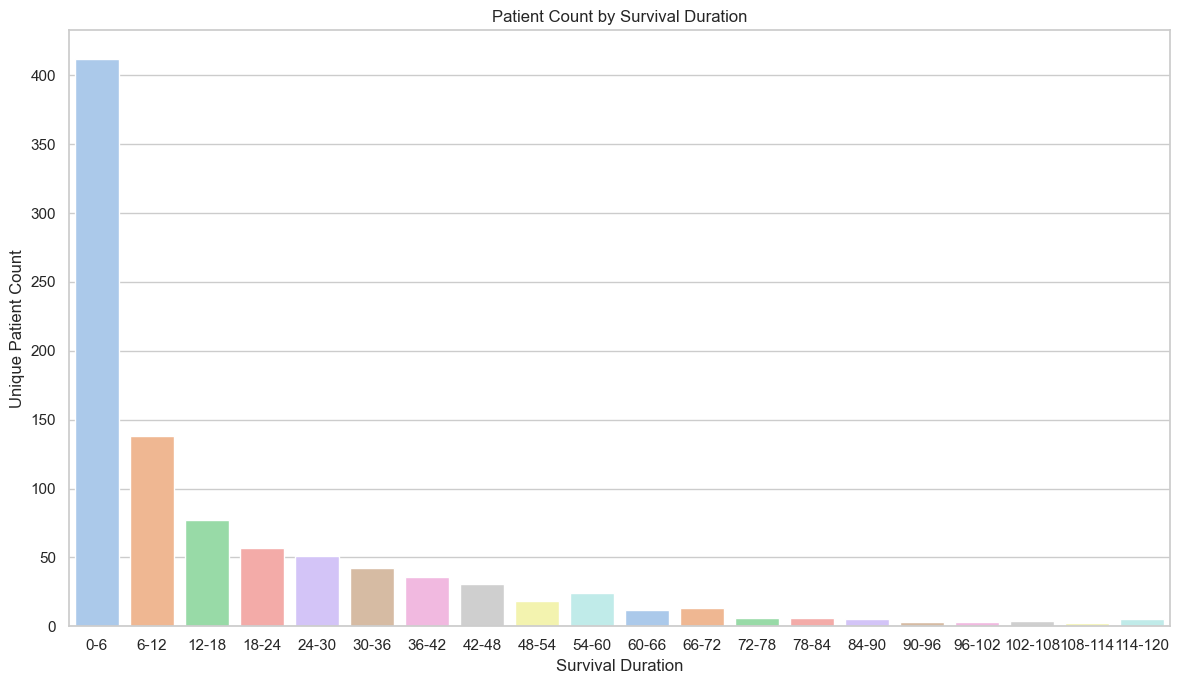

In [189]:
plt.figure(figsize=(12, 7))

# Create a bar plot
sns.barplot(data=counts_survival_NSCLC_df, x='Survival Binned', y='Unique Patient Count', palette='pastel')

# Adding titles and labels
plt.title('Patient Count by Survival Duration')
plt.xlabel('Survival Duration')
plt.ylabel('Unique Patient Count')

# Display the bar graph
plt.tight_layout()
plt.show()

C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


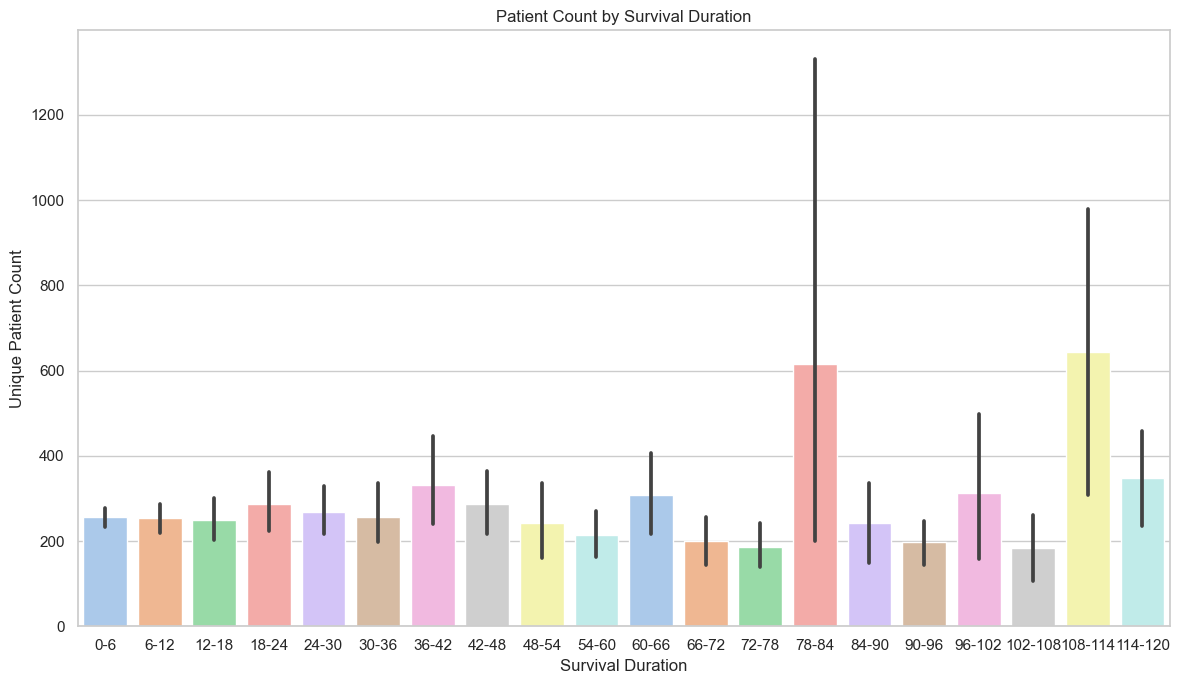

In [190]:
plt.figure(figsize=(12, 7))

# Create a bar plot
sns.barplot(data=survival_NSCLC_df, x='Survival Binned', y='Mutation Count', palette='pastel')

# Adding titles and labels
plt.title('Patient Count by Survival Duration')
plt.xlabel('Survival Duration')
plt.ylabel('Unique Patient Count')

# Display the bar graph
plt.tight_layout()
plt.show()

In [212]:
bins = list(range(0, 1500, 250))  # Create bins from 0 to 1500 in increments of 5
labels = [f'{i}-{i + 500}' for i in bins[:-1]]  # Create labels for the bins

# Create a new column for binned mutation counts
survival_NSCLC_df['mutation Binned'] = pd.cut(
    survival_NSCLC_df['Mutation Count'], 
    bins=bins, 
    labels=labels, 
    right=False
)

# Group by the binned mutation counts and calculate the average overall survival
bins_df = survival_NSCLC_df.groupby('mutation Binned')['Overall Survival (Months)'].mean().reset_index()

# Rename the columns for clarity
bins_df.columns = ['Mutation Binned', 'Average Overall Survival']

# Display the result
print(bins_df)


  Mutation Binned  Average Overall Survival
0           0-500                 17.756609
1         250-750                 19.883686
2        500-1000                 31.082115
3        750-1250                 18.755714
4       1000-1500                 29.063750


C:\Users\nefer\AppData\Local\Temp\ipykernel_32884\3133047530.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survival_NSCLC_df['mutation Binned'] = pd.cut(
C:\Users\nefer\AppData\Local\Temp\ipykernel_32884\3133047530.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bins_df = survival_NSCLC_df.groupby('mutation Binned')['Overall Survival (Months)'].mean().reset_index()


C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


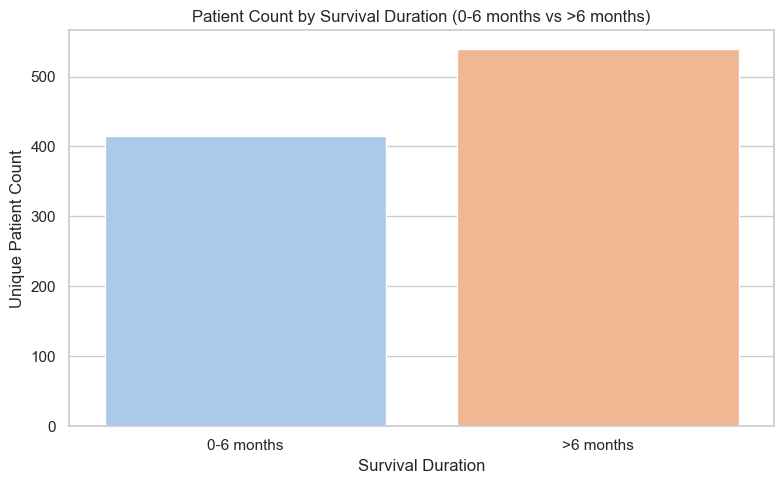

In [191]:
plt.figure(figsize=(8, 5))

# Create a bar plot
sns.barplot(data=counts_survival_bins2_df, x='Survival Binned2', y='Unique Patient Count', palette='pastel')

# Adding titles and labels
plt.title('Patient Count by Survival Duration (0-6 months vs >6 months)')
plt.xlabel('Survival Duration')
plt.ylabel('Unique Patient Count')

# Display the bar graph
plt.tight_layout()
plt.show()

In [192]:


# Group by the binned survival months and count unique Patient IDs
counts_survival_bins3_df = survival_NSCLC_df.groupby('Survival Binned2')['TMB (nonsynonymous)'].nunique().reset_index()

# Rename the count column for clarity
counts_survival_bins3_df

C:\Users\nefer\AppData\Local\Temp\ipykernel_32884\2531203359.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_survival_bins3_df = survival_NSCLC_df.groupby('Survival Binned2')['TMB (nonsynonymous)'].nunique().reset_index()


,Survival Binned2,TMB (nonsynonymous)
0,0-6 months,271
1,>6 months,336


C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


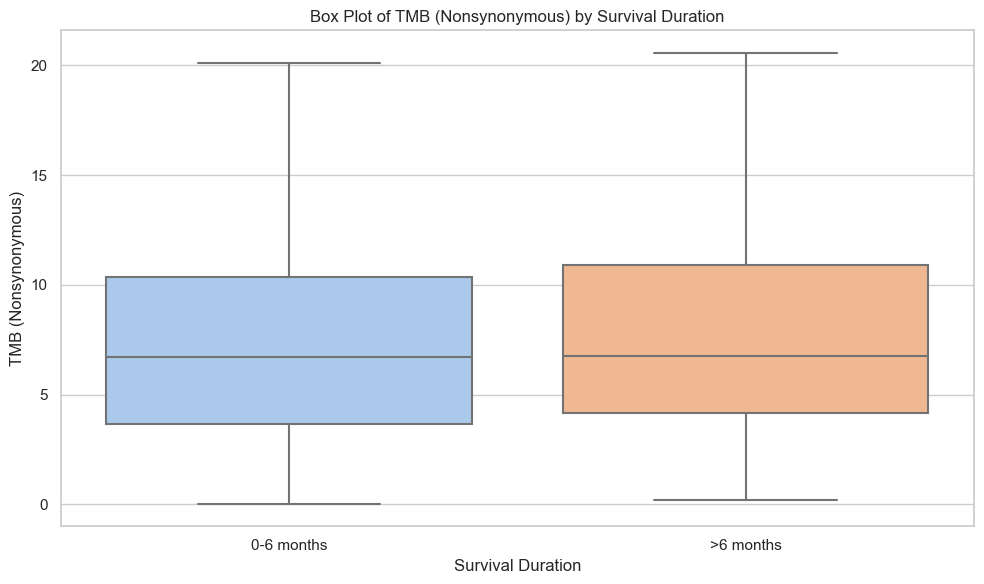

In [193]:
plt.figure(figsize=(10, 6))


sns.boxplot(data=survival_NSCLC_df, x='Survival Binned2', y='TMB (nonsynonymous)', palette='pastel', showfliers=False)

# Adding titles and labels
plt.title('Box Plot of TMB (Nonsynonymous) by Survival Duration')
plt.xlabel('Survival Duration')
plt.ylabel('TMB (Nonsynonymous)')

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


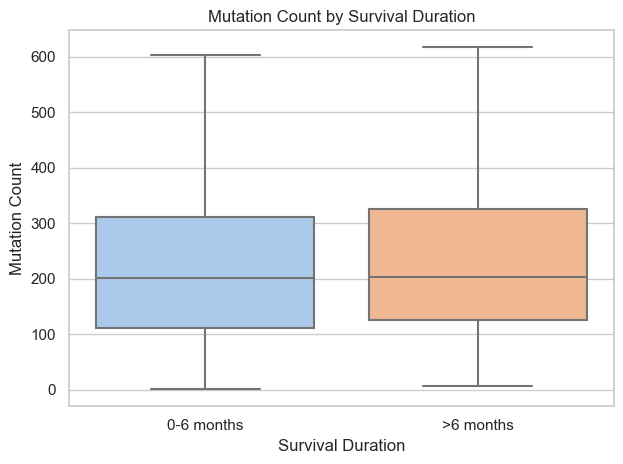

In [194]:
# Group by the binned survival months and count unique Patient ID

sns.boxplot(data=survival_NSCLC_df, x='Survival Binned2', y='Mutation Count', palette='pastel', showfliers=False)

# Adding titles and labels
plt.title('Mutation Count by Survival Duration')
plt.xlabel('Survival Duration')
plt.ylabel('Mutation Count')

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


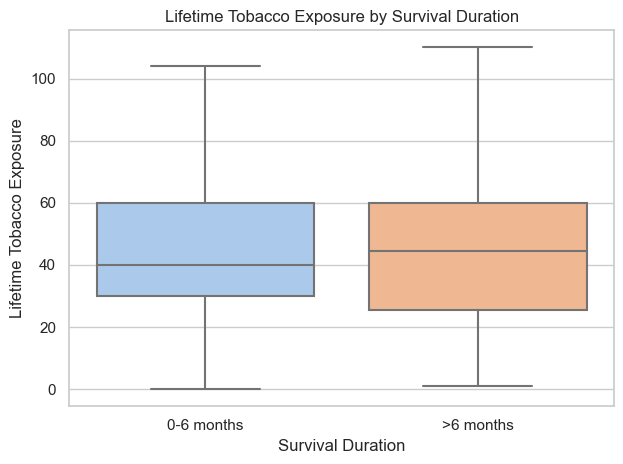

In [195]:
# Group by the binned survival months and count unique Patient ID

sns.boxplot(data=survival_NSCLC_df, x='Survival Binned2', y='Lifetime Tobacco Exposure', palette='pastel', showfliers=False)

# Adding titles and labels
plt.title('Lifetime Tobacco Exposure by Survival Duration')
plt.xlabel('Survival Duration')
plt.ylabel('Lifetime Tobacco Exposure')

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


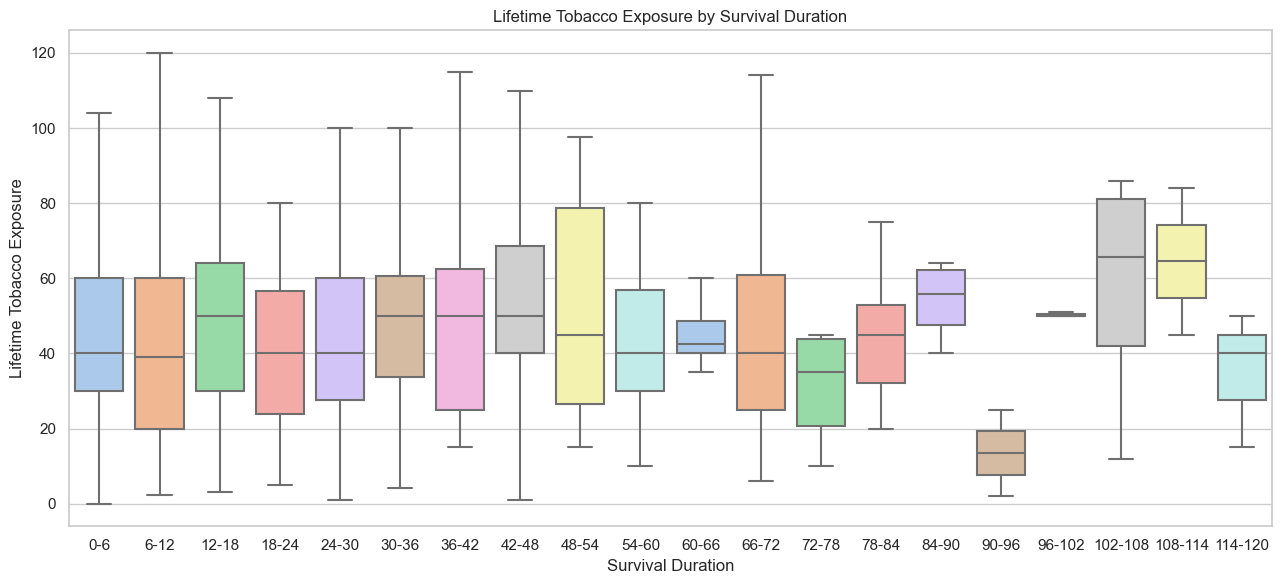

In [200]:
plt.figure(figsize=(13, 6))
# Group by the binned survival months and count unique Patient ID

sns.boxplot(data=survival_NSCLC_df, x='Survival Binned', y='Lifetime Tobacco Exposure', palette='pastel', showfliers=False)

# Adding titles and labels
plt.title('Lifetime Tobacco Exposure by Survival Duration')
plt.xlabel('Survival Duration')
plt.ylabel('Lifetime Tobacco Exposure')

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\nefer\AppData\Local\Temp\ipykernel_32884\2779072860.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_tobacco_exposure_by_subtype = survival_NSCLC_df.groupby(['Survival Binned', 'Cancer Subtype'])['Lifetime Tobacco Exposure'].mean().reset_index()
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
C:\Users\nefer\anaconda3_2\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pas

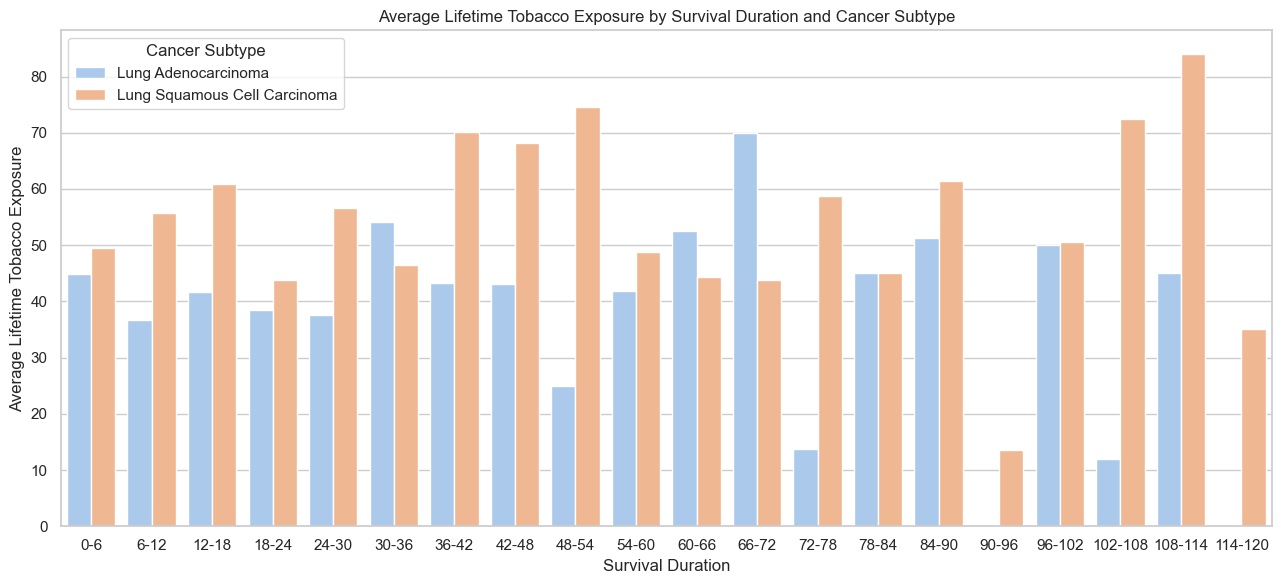

In [207]:
plt.figure(figsize=(13, 6))

# Calculate the average Lifetime Tobacco Exposure for each survival bin and cancer subtype
average_tobacco_exposure_by_subtype = survival_NSCLC_df.groupby(['Survival Binned', 'Cancer Subtype'])['Lifetime Tobacco Exposure'].mean().reset_index()

# Create a bar plot
sns.barplot(data=average_tobacco_exposure_by_subtype, x='Survival Binned', y='Lifetime Tobacco Exposure', hue='Cancer Subtype', palette='pastel')

# Adding titles and labels
plt.title('Average Lifetime Tobacco Exposure by Survival Duration and Cancer Subtype')
plt.xlabel('Survival Duration')
plt.ylabel('Average Lifetime Tobacco Exposure')

# Display the plot with a legend
plt.legend(title='Cancer Subtype')
plt.tight_layout()
plt.show()



In [197]:
columns_to_keep = ['Patient ID', 'Cancer Subtype', 'Overall Survival (Months)', 'Mutation Count', 'TMB (nonsynonymous)', 'TMB (nonsynonymous)','Lifetime Tobacco Exposure']


